In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms


import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
data_dir = "data/image_data"

model_name = "alexnet"

num_classes = 2

batch_size = 8


num_epochs = 15

feature_extract = True

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    tik = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                # calculating losses for plotting and statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)#(pred == labels).sum().item()
                                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    tok = time.time()
    time_taken = tok - tik
    print('Training complete in {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later.

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract= True, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

model.classifier[6] = nn.Linear(4096,num_classes)


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [8]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.5119 Acc: 0.8115
val Loss: 0.3302 Acc: 0.9020

Epoch 1/14
----------
train Loss: 0.3008 Acc: 0.9139
val Loss: 0.4275 Acc: 0.9085

Epoch 2/14
----------
train Loss: 0.2024 Acc: 0.9303
val Loss: 0.4940 Acc: 0.8889

Epoch 3/14
----------
train Loss: 0.3109 Acc: 0.9098
val Loss: 0.4543 Acc: 0.8889

Epoch 4/14
----------
train Loss: 0.2014 Acc: 0.9303
val Loss: 0.4076 Acc: 0.9216

Epoch 5/14
----------
train Loss: 0.1636 Acc: 0.9344
val Loss: 0.4094 Acc: 0.8824

Epoch 6/14
----------
train Loss: 0.1232 Acc: 0.9467
val Loss: 0.5755 Acc: 0.8954

Epoch 7/14
----------
train Loss: 0.1600 Acc: 0.9508
val Loss: 0.6391 Acc: 0.8889

Epoch 8/14
----------
train Loss: 0.1861 Acc: 0.9385
val Loss: 0.4534 Acc: 0.8889

Epoch 9/14
----------
train Loss: 0.1175 Acc: 0.9549
val Loss: 0.3980 Acc: 0.8889

Epoch 10/14
----------
train Loss: 0.1973 Acc: 0.9303
val Loss: 0.5370 Acc: 0.8889

Epoch 11/14
----------
train Loss: 0.1886 Acc: 0.9385
val Loss: 0.4838 Acc: 0.8562

Ep

Epoch 0/14
----------
train Loss: 0.6939 Acc: 0.4467
val Loss: 0.6935 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6937 Acc: 0.4467
val Loss: 0.6928 Acc: 0.5425

Epoch 2/14
----------
train Loss: 0.6929 Acc: 0.4877
val Loss: 0.6929 Acc: 0.6078

Epoch 3/14
----------
train Loss: 0.6934 Acc: 0.4918
val Loss: 0.6932 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6926 Acc: 0.5451
val Loss: 0.6925 Acc: 0.6275

Epoch 6/14
----------
train Loss: 0.6929 Acc: 0.4877
val Loss: 0.6928 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6926 Acc: 0.5328
val Loss: 0.6924 Acc: 0.4771

Epoch 8/14
----------
train Loss: 0.6924 Acc: 0.5410
val Loss: 0.6921 Acc: 0.4967

Epoch 9/14
----------
train Loss: 0.6927 Acc: 0.5123
val Loss: 0.6908 Acc: 0.6863

Epoch 10/14
----------
train Loss: 0.6925 Acc: 0.5287
val Loss: 0.6911 Acc: 0.6405

Epoch 11/14
----------
train Loss: 0.6925 Acc: 0.5451
val Loss: 0.6904 Acc: 0.6797

Ep

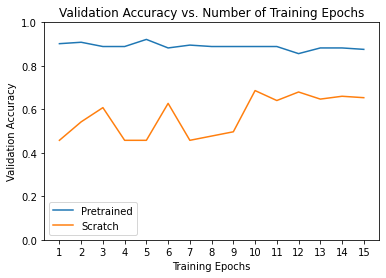

In [9]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [12]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'alex_net_custom.pt'


torch.save(scratch_model.state_dict(), model_dir+model_name)